In [1]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
from pydub import AudioSegment
from scipy.signal import find_peaks

C:\Users\dave\anaconda3\envs\haikoo\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
dir_path = r"C:\Users\dave\aiffel\aiffelton_project\dataset\set 3"
class_names = next(os.walk(dir_path))[1]
class_names

['bellypain', 'discomfort', 'hungry', 'tired']

In [3]:
audio_path = [os.path.join(dir_path, name) for name in class_names]
audio_path

['C:\\Users\\dave\\aiffel\\aiffelton_project\\dataset\\set 3\\bellypain',
 'C:\\Users\\dave\\aiffel\\aiffelton_project\\dataset\\set 3\\discomfort',
 'C:\\Users\\dave\\aiffel\\aiffelton_project\\dataset\\set 3\\hungry',
 'C:\\Users\\dave\\aiffel\\aiffelton_project\\dataset\\set 3\\tired']

In [4]:
bpain_audio = glob.glob(os.path.join(audio_path[0], '*.wav'))
discomf_audio = glob.glob(os.path.join(audio_path[1], '*.wav'))
hungry_audio = glob.glob(os.path.join(audio_path[2], '*.wav'))
tired_audio = glob.glob(os.path.join(audio_path[3], '*.wav'))

In [5]:
audio_num_byclass = {
    'bpain': len(bpain_audio),
    'discomf': len(discomf_audio),
    'hungry': len(hungry_audio),
    'tired': len(tired_audio)
}

for k, v in audio_num_byclass.items():
    print(f'num audio for the class {k}: {v}')

num audio for the class bpain: 49
num audio for the class discomf: 47
num audio for the class hungry: 49
num audio for the class tired: 50


## **Data Imbalance Check**
- number of data for each class visualized

<function matplotlib.pyplot.show(close=None, block=None)>

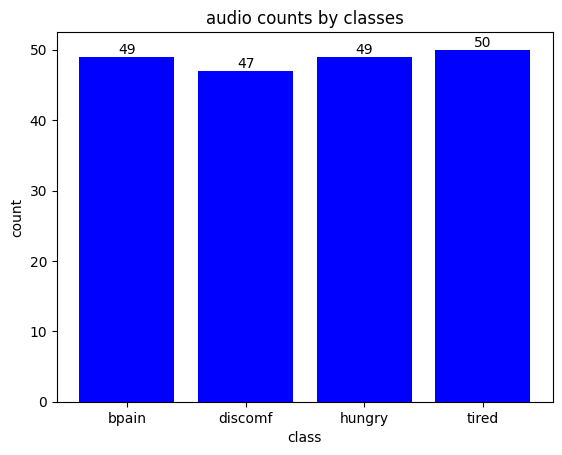

In [6]:
plt.bar(audio_num_byclass.keys(), audio_num_byclass.values(), color ='b')

for class_label, count in audio_num_byclass.items():
    plt.text(class_label, count, str(count), ha='center', va='bottom')

plt.xlabel('class')
plt.ylabel('count')
plt.title('audio counts by classes')
plt.show

## **sample rate, duration by class**

In [7]:
bpain_sr = [(librosa.load(audio, sr=None)[1]) for audio in bpain_audio]
discomf_sr = [(librosa.load(audio, sr=None)[1]) for audio in discomf_audio]
hungry_sr = [(librosa.load(audio, sr=None)[1]) for audio in hungry_audio]
tired_sr = [(librosa.load(audio, sr=None)[1]) for audio in tired_audio]

(8000, 48000, 44100) (9, 37, 3)
(8000, 44100) (30, 17)
(8000, 44100) (43, 6)
(8000, 44100, 48000, 16000) (17, 3, 22, 8)


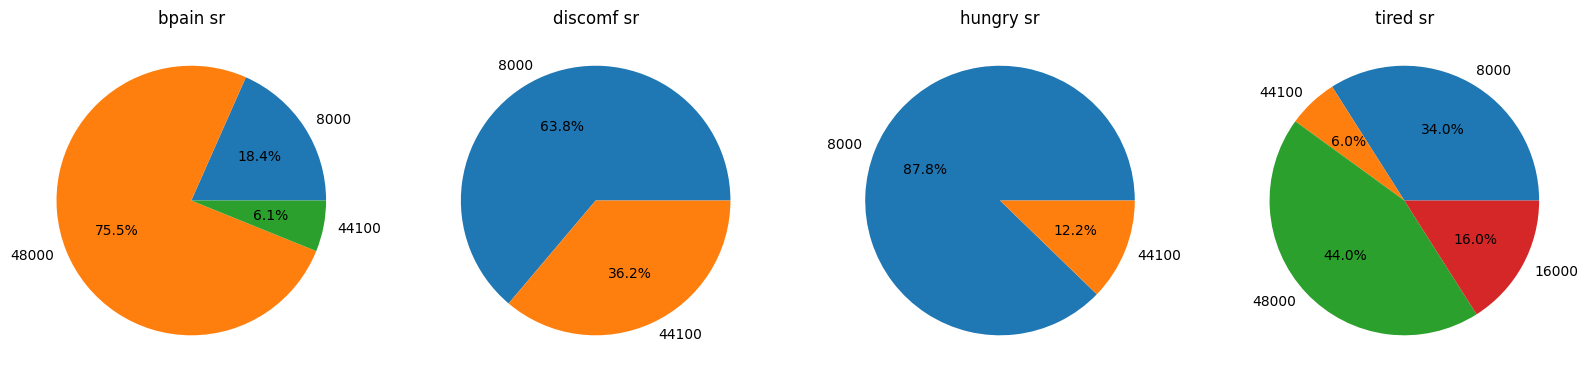

In [8]:
from collections import Counter
audio_sr_byclass = {
    'bpain': bpain_sr,
    'discomf': discomf_sr,
    'hungry': hungry_sr,
    'tired': tired_sr
}

# Create a figure with 4 subplots
plt.figure(figsize=(20, 5))

for i, (k, v) in enumerate(audio_sr_byclass.items()):
    # Count the occurrences of each sample rate
    sr_counts = Counter(v)
    labels, counts = zip(*sr_counts.items())
    print(labels, counts)

    # Create a subplot for each class
    plt.subplot(1, 4, i+1)
    plt.pie(counts, labels=labels, autopct ='%.1f%%')
    plt.title(f'{k} sr')

plt.show()

In [9]:
audio_path = {
    'bpain': bpain_audio,
    'discomf': discomf_audio,
    'hungry': hungry_audio,
    'tired': tired_audio
}

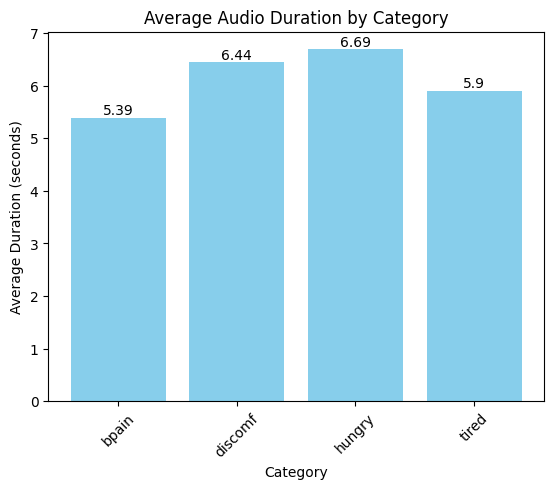

In [10]:
average_durations = {}

# Calculate average durations
for name, audios in audio_path.items():
    total_duration = 0
    for path in audios:
        audio = AudioSegment.from_file(path)
        total_duration += audio.duration_seconds
    average_duration = total_duration / len(audios) if audios else 0
    average_durations[name] = average_duration

# Names and averages for plotting
names = list(average_durations.keys())
averages = list(average_durations.values())

for idx, avg in enumerate(averages):
    avg = '{:.2f}'.format(avg)
    averages[idx] = float(avg)
# Plotting
fig, ax = plt.subplots()
ax.bar(names, averages, color='skyblue')
for name, avg in zip(names, averages):
    plt.text(name, avg, str(avg), ha='center', va='bottom')
ax.set_xlabel('Category')
ax.set_ylabel('Average Duration (seconds)')
ax.set_title('Average Audio Duration by Category')

plt.xticks(rotation=45)
plt.show()

## **Average Mel Spectrogram by Class**
- average pitch or frequency is calculated by picking the range of the most prevalent frequencies in the Mel Spectrogram
- The range of frequencies is roughly determined as demonstrated in the bounding box of the image below:

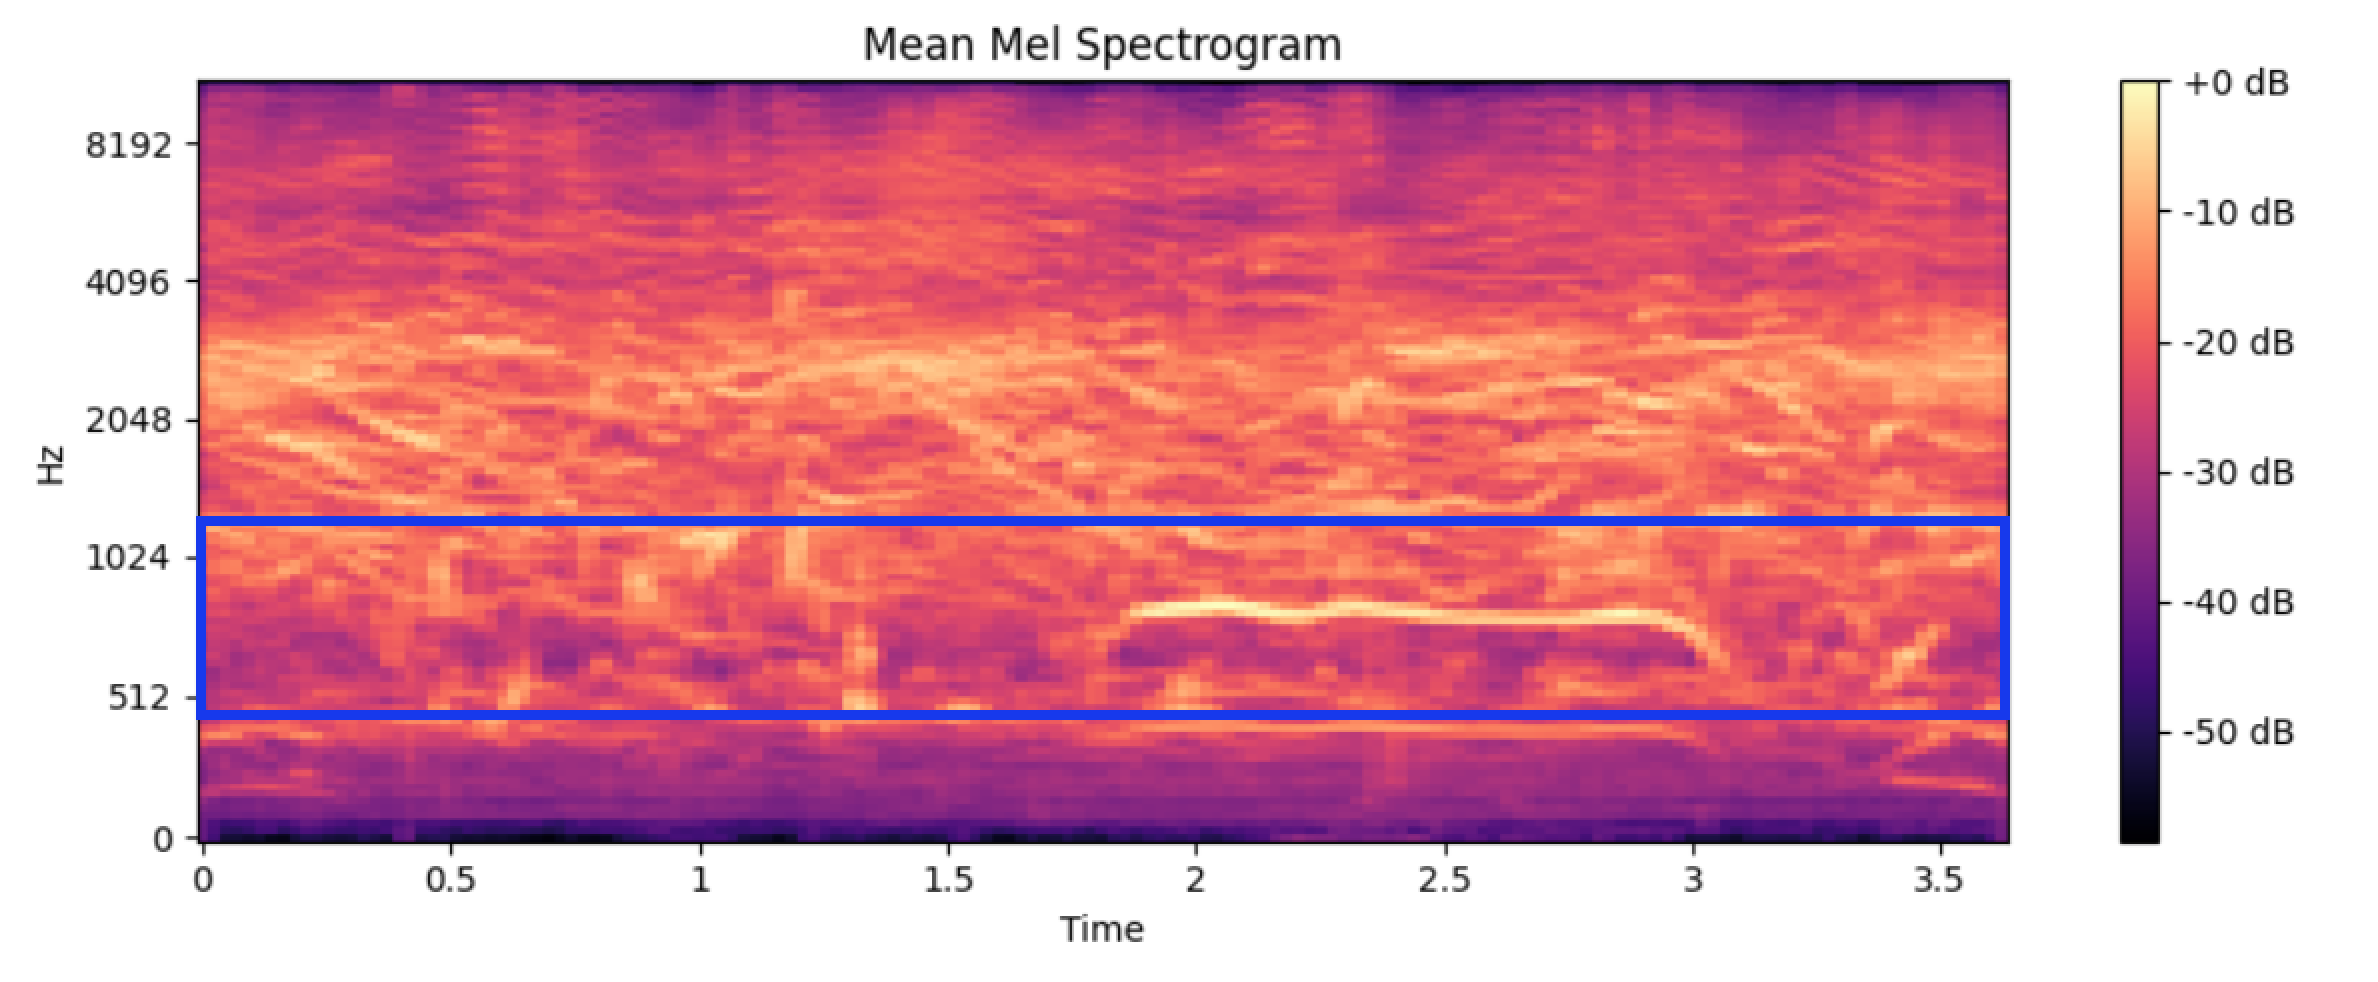

In [11]:
# Bellypain audio to spectrogram
melspec_belly = []

for path in bpain_audio:
    y, sr = librosa.load(path, sr = 20000, duration=5.0)
    S_db = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    melspec_belly.append(S_db)

In [12]:
melspec_belly_arr = np.array(melspec_belly)

In [13]:
belly_mean_melspec = np.mean(melspec_belly_arr, axis=0)
belly_mean_melspec.shape

(128, 196)

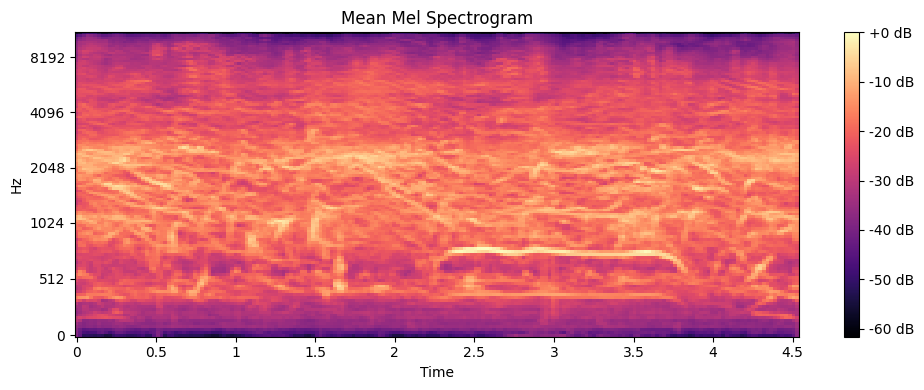

In [14]:
plt.figure(figsize=(10, 4))

# Displaying the spectrogram
librosa.display.specshow(librosa.power_to_db(belly_mean_melspec, ref=np.max),
                         y_axis='mel', x_axis='time')

plt.colorbar(format='%+2.0f dB')
plt.title('Mean Mel Spectrogram')
plt.tight_layout()
plt.show()

In [15]:
mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr/2)
lower_bound_idx = np.argmin(np.abs(mel_frequencies - 600))
upper_bound_idx = np.argmin(np.abs(mel_frequencies - 1024))

# Extract the part of the mel spectrogram corresponding to this range
target_range = belly_mean_melspec[lower_bound_idx:upper_bound_idx+1, :]

# find the average frequency in this range
# multiply the magnitude by the frequency to get a weighted sum
weighted_frequencies = np.sum(target_range * mel_frequencies[lower_bound_idx:upper_bound_idx+1, np.newaxis], axis=0)
total_magnitude = np.sum(target_range, axis=0)
average_frequency = np.sum(weighted_frequencies) / np.sum(total_magnitude)

average_frequency

826.7992411983607

In [16]:
# discomf audio to spectrogram
melspec_discomf = []

for path in discomf_audio:
    y, sr = librosa.load(path, sr = 16000, duration=5.0)
    S_db = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    melspec_discomf.append(S_db)

In [17]:
melspec_discomf_arr = np.array(melspec_discomf)
discomf_mean_melspec = np.mean(melspec_discomf_arr, axis=0)
discomf_mean_melspec.shape

(128, 157)

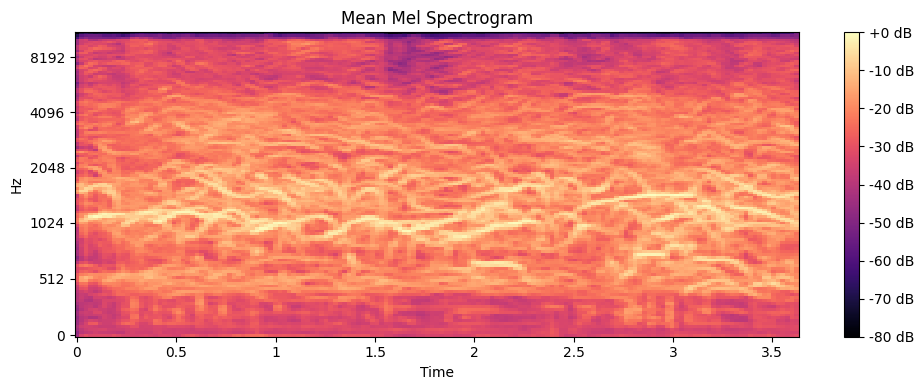

In [18]:
plt.figure(figsize=(10, 4))

# Displaying the spectrogram
librosa.display.specshow(librosa.power_to_db(discomf_mean_melspec, ref=np.max),
                         y_axis='mel', x_axis='time')

plt.colorbar(format='%+2.0f dB')
plt.title('Mean Mel Spectrogram')
plt.tight_layout()
plt.show()

In [19]:
mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr/2)
lower_bound_idx = np.argmin(np.abs(mel_frequencies - 950))
upper_bound_idx = np.argmin(np.abs(mel_frequencies - 1524))

# Extract the part of the mel spectrogram corresponding to this range
target_range = discomf_mean_melspec[lower_bound_idx:upper_bound_idx+1, :]

# find the average frequency in this range
# multiply the magnitude by the frequency to get a weighted sum
weighted_frequencies = np.sum(target_range * mel_frequencies[lower_bound_idx:upper_bound_idx+1, np.newaxis], axis=0)
total_magnitude = np.sum(target_range, axis=0)
average_frequency = np.sum(weighted_frequencies) / np.sum(total_magnitude)

average_frequency

1164.6164770991693

In [20]:
# hungry audio to mel spec
melspec_hungry = []

for path in hungry_audio:
    y, sr = librosa.load(path, sr = 16000, duration=5.0)
    S_db = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    melspec_hungry.append(S_db)

In [21]:
melspec_hungry_arr = np.array(melspec_hungry)
hungry_mean_melspec = np.mean(melspec_hungry_arr, axis=0)
hungry_mean_melspec.shape

(128, 157)

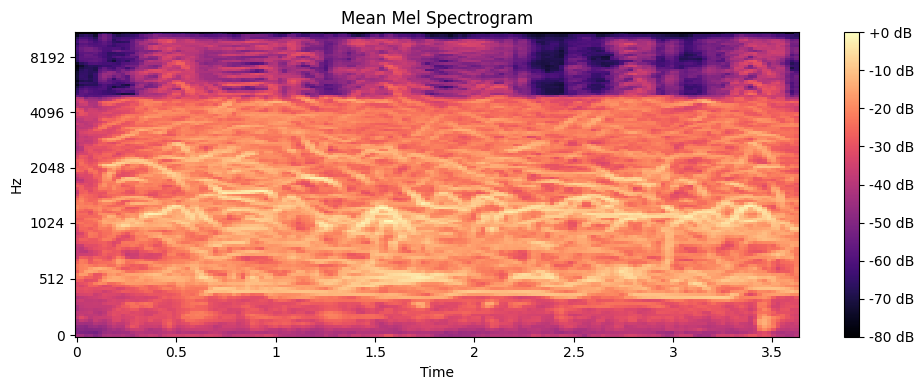

In [22]:
plt.figure(figsize=(10, 4))

# Displaying the spectrogram
librosa.display.specshow(librosa.power_to_db(hungry_mean_melspec, ref=np.max),
                         y_axis='mel', x_axis='time')

plt.colorbar(format='%+2.0f dB')
plt.title('Mean Mel Spectrogram')
plt.tight_layout()
plt.show()

In [23]:
mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr/2)
lower_bound_idx = np.argmin(np.abs(mel_frequencies - 450))
upper_bound_idx = np.argmin(np.abs(mel_frequencies - 1400))

# Extract the part of the mel spectrogram corresponding to this range
target_range = hungry_mean_melspec[lower_bound_idx:upper_bound_idx+1, :]

# find the average frequency in this range
# multiply the magnitude by the frequency to get a weighted sum
weighted_frequencies = np.sum(target_range * mel_frequencies[lower_bound_idx:upper_bound_idx+1, np.newaxis], axis=0)
total_magnitude = np.sum(target_range, axis=0)
average_frequency = np.sum(weighted_frequencies) / np.sum(total_magnitude)

average_frequency

920.7060341627745

In [24]:
# tired
melspec_tired = []

for path in tired_audio:
    y, sr = librosa.load(path, sr = 16000, duration=5.0)
    S_db = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    melspec_tired.append(S_db)

In [25]:
melspec_tired_arr = np.array(melspec_tired)
tired_mean_melspec = np.mean(melspec_tired_arr, axis=0)
tired_mean_melspec.shape

(128, 157)

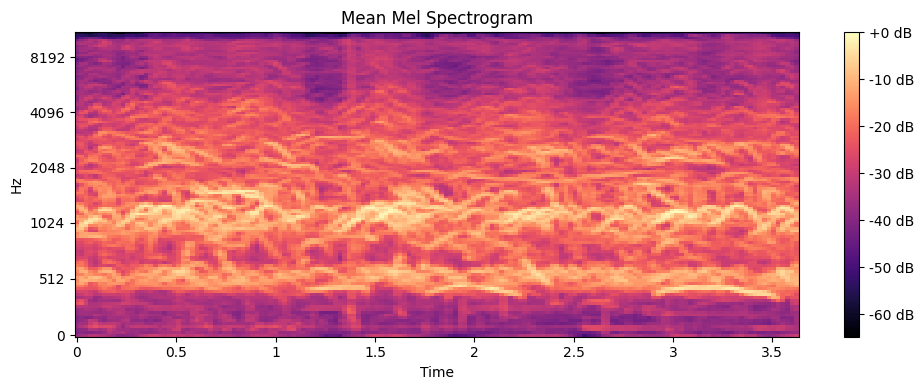

In [26]:
plt.figure(figsize=(10, 4))

# Displaying the spectrogram
librosa.display.specshow(librosa.power_to_db(tired_mean_melspec, ref=np.max),
                         y_axis='mel', x_axis='time')

plt.colorbar(format='%+2.0f dB')
plt.title('Mean Mel Spectrogram')
plt.tight_layout()
plt.show()

In [27]:
mel_frequencies = librosa.mel_frequencies(n_mels=128, fmin=0, fmax=sr/2)
lower_bound_idx = np.argmin(np.abs(mel_frequencies - 450))
upper_bound_idx = np.argmin(np.abs(mel_frequencies - 1024))

# Extract the part of the mel spectrogram corresponding to this range
target_range = tired_mean_melspec[lower_bound_idx:upper_bound_idx+1, :]

# find the average frequency in this range
# multiply the magnitude by the frequency to get a weighted sum
weighted_frequencies = np.sum(target_range * mel_frequencies[lower_bound_idx:upper_bound_idx+1, np.newaxis], axis=0)
total_magnitude = np.sum(target_range, axis=0)
average_frequency = np.sum(weighted_frequencies) / np.sum(total_magnitude)

average_frequency

815.3589108635352

In [28]:
all_path_dict= {
    'bpain': bpain_audio, 
    'discomf': discomf_audio,
    'hungry': hungry_audio,
    'tired':tired_audio
}

In [29]:
def peak_byclass(dict):
    peak_byclass_dict = {}
    for class_name, val in peak_dict.items():
        if isinstance(val, tuple):
            val = [val]
        max, mean_num = zip(*val)
        peak_byclass_dict[f'{class_name}_max_peak'] = max[0]
        peak_byclass_dict[f'{class_name}_meannum_peak'] = mean_num[0]

    return peak_byclass_dict

In [30]:
def analyze_audio_beta(audio_files):
    class_results = {}

    for class_name, files in audio_files.items():
        average_magnitudes = []
        num_peaks = []

        for file in files:
            # Load the audio file
            y, sr = librosa.load(file)

            # Apply FFT and get the magnitude spectrum
            fft = np.fft.fft(y)
            magnitude = np.abs(fft)

            # Find peaks
            peaks, _ = find_peaks(magnitude, height=25.7)

            # Calculate the max peak value and the number of peaks
            average_magnitude = np.mean(magnitude[peaks])
            average_magnitudes.append(average_magnitude)
            # if peaks.size > 0 else 0
            # print(max_peak_val)
            num_peak = len(peaks)

            num_peaks.append(num_peak)
            

        # Calculate the mean of max peak values and mean number of peaks for the class
        # Calculate the mean of average magnitudes for the class
        mean_average_magnitude = np.mean(average_magnitudes) if average_magnitudes else 0
        mean_num_peak = np.mean(num_peaks) if num_peaks else 0

        class_results[class_name] = (mean_average_magnitude, mean_num_peak)

    return class_results

In [31]:
mag_n_nump_dict = analyze_audio_beta(all_path_dict)
mag_n_nump_dict

{'bpain': (61.553382373157476, 9083.102040816326),
 'discomf': (97.01299594146641, 9907.148936170213),
 'hungry': (98.78528109821629, 10243.510204081633),
 'tired': (76.40144561318347, 9031.08)}

In [32]:
def mag_n_nump_byclass(dict):
    mag_n_nump_byclass_dict = {}
    for class_name, val in dict.items():
        if isinstance(val, tuple):
            val = [val]
        avg_mag, mean_num = zip(*val)
        mag_n_nump_byclass_dict[f'{class_name}_avg_mag'] = avg_mag[0]
        mag_n_nump_byclass_dict[f'{class_name}_meannum_peak'] = mean_num[0]

    return mag_n_nump_byclass_dict

In [33]:
mag_np_descr_dict = mag_n_nump_byclass(mag_n_nump_dict)
mag_np_descr_dict

{'bpain_avg_mag': 61.553382373157476,
 'bpain_meannum_peak': 9083.102040816326,
 'discomf_avg_mag': 97.01299594146641,
 'discomf_meannum_peak': 9907.148936170213,
 'hungry_avg_mag': 98.78528109821629,
 'hungry_meannum_peak': 10243.510204081633,
 'tired_avg_mag': 76.40144561318347,
 'tired_meannum_peak': 9031.08}

In [34]:
mag_np_df = pd.DataFrame([mag_np_descr_dict])
mag_np_df

,bpain_avg_mag,bpain_meannum_peak,discomf_avg_mag,discomf_meannum_peak,hungry_avg_mag,hungry_meannum_peak,tired_avg_mag,tired_meannum_peak
0,61.553382,9083.102041,97.012996,9907.148936,98.785281,10243.510204,76.401446,9031.08


C:\Users\dave\anaconda3\envs\haikoo\lib\site-packages\matplotlib\cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
C:\Users\dave\anaconda3\envs\haikoo\lib\site-packages\matplotlib\text.py:1461: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
C:\Users\dave\anaconda3\envs\haikoo\lib\site-packages\matplotlib\text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))


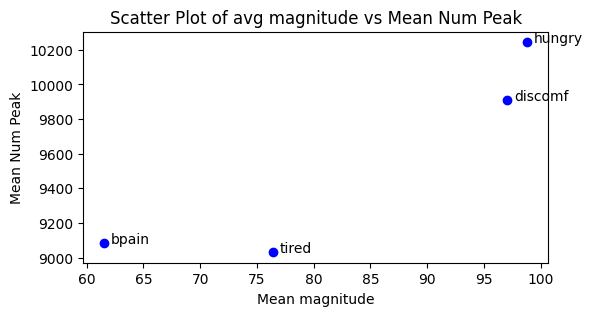

In [35]:
# Reshaping and organizing the data for plotting
categories = set(cat.rsplit('_', 2)[0] for cat in mag_np_df.keys())
avg_mg = [mag_np_df[f'{cat}_avg_mag'] for cat in categories]
mean_nums_ = [mag_np_df[f'{cat}_meannum_peak'] for cat in categories]

# Creating the scatter plot
plt.figure(figsize=(6, 3))
plt.scatter(avg_mg, mean_nums_, color='blue')

# Adding labels and title
plt.title('Scatter Plot of avg magnitude vs Mean Num Peak')
plt.xlabel('Mean magnitude')
plt.ylabel('Mean Num Peak')
for i, cat in enumerate(categories):
    plt.annotate(cat,
                 (avg_mg[i], mean_nums_[i]),
                textcoords='offset points',
                xytext=(5,0),
                 ha='left')

# Showing the plot
plt.show()

In [36]:
total_df = {
    'average_magnitude': [61.5, 97.0, 98.8, 76.4],
    'average_number_harmonics': [9082, 9906, 10242, 9030],
    'average_frequency': [826.8, 1164.8, 920.7, 815.4],
    'index': ['bellypain', 'discomfort', 'hungry', 'tired']
}

feat_df = pd.DataFrame(total_df)
feat_df

,average_magnitude,average_number_harmonics,average_frequency,index
0,61.5,9082,826.8,bellypain
1,97.0,9906,1164.8,discomfort
2,98.8,10242,920.7,hungry
3,76.4,9030,815.4,tired


In [37]:
feat_df.set_index(['index'], inplace=True)

C:\Users\dave\AppData\Local\Temp\ipykernel_6960\1772273582.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(x[i], y[i], z[i], txt, size=10, zorder=2, color='k')


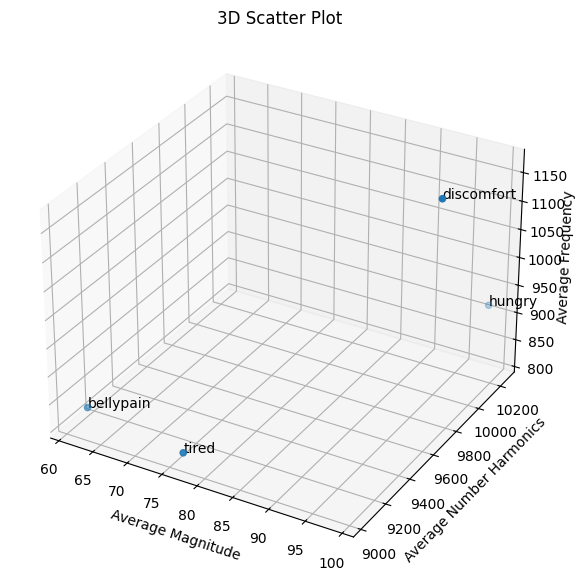

In [38]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Extracting the data from the dataframe
x = feat_df['average_magnitude']
y = feat_df['average_number_harmonics']
z = feat_df['average_frequency']

# Scatter plot
scatter = ax.scatter(x, y, z)

# Adding labels
ax.set_xlabel('Average Magnitude')
ax.set_ylabel('Average Number Harmonics')
ax.set_zlabel('Average Frequency', labelpad=-0.00000001)

# Adding title
ax.set_title('3D Scatter Plot')

# Annotating each point
for i, txt in enumerate(feat_df.index):
    ax.text(x[i], y[i], z[i], txt, size=10, zorder=2, color='k')

plt.show()